In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [12]:
log_dir = "local_log/hogwild"
logs = [f for f in listdir(log_dir) if isfile(join(log_dir, f)) and '.' not in f]

PARENTHESIS_RE = "\((.*)\)"


def read_log(log_file, cut=False):
    with open(join(log_dir, log_file), "r", encoding='latin-1') as f:
        lines = f.readlines()
        params = list(filter(lambda x: "PARAMETERS" in x, lines))
        assert len(params) == 1
        params = params[0].split()[2].split(',')
        params = dict(map(parse_params, params))
        
        losses = list(filter(lambda x: "SUMMARY" in x, lines))
        losses = list(map(read_summary, losses))
        
        events = list(filter(lambda x: "SUMMARY" not in x and "PARAMETERS" not in x and "ACCURACY" not in x, lines))
        events = list(map(read_time, events))
        
        accs = list(filter(lambda x: "ACCURACY" in x, lines))
        #assert len(accs) == 1
        #accs = read_accs(accs[0])
        
        df = pd.DataFrame.from_dict(losses)
        for name, p in params.items():
            df[name] = p
        #for name, p in accs.items():
        #    df[name] = p
        df["end_time"] = (df["end_time"] - df["end_time"].min()) / 1000000000
        if cut:
            th =  df["val_loss"].min() * 1.01
            i = 0
            for idx, rows in df.iterrows():
                if rows["val_loss"] > th:
                    i+=1
            e = df.head(i)["end_time"].min()
            df = df.head(i)
        
        return df
    
def read_accs(line):
    line = line.split()
    accs = re.findall(PARENTHESIS_RE, line[1])[0]
    time = float(line[2])
    acc, pos, neg = (float(i.split("=")[1]) for i in accs.split(","))
    return {"acc": acc, "pos":pos, "neg":neg}
    
def parse_params(param):
    split = param.split("=")
    key = split[0]
    value = split[1]
    try:
        value = int(value)
    except:
        try:
            value = float(value)
        except:
            pass
    return key, value
        
def read_summary(line):
    line = line.split()
    losses = re.findall(PARENTHESIS_RE, line[1])[0]
    time = float(line[2])
    validation_loss = float(losses.split("=")[1])
    return {"end_time": time, "val_loss": validation_loss}

def read_time(line):
    line = line.split()
    epoch = int(re.findall(PARENTHESIS_RE, line[1])[0])
    time = float(line[-1])
    event = line[2]
    return {"epoch": epoch, event + "_TIME": time}
    
    
data = list(map(read_log, logs))
data = reduce(lambda x, y: pd.concat([x,y]), data)
data = data.set_index(["WORKERS",  "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE"])

def plot_all(workers=None, batch_size=None, hist=False):
    fig = plt.figure(figsize=(14,8))
    ax = plt.gca()
    if hist:
        plt.figure(figsize=(14,8))
        ax2 = plt.gca()
    labels = []
    d = data
    title = "Workers/Batch size"
    if workers:
        d = d[np.in1d(d.index.get_level_values(0), [workers])]
        title="Batch Size"
    if batch_size:
        d = d[np.in1d(d.index.get_level_values(1), [batch_size])]
        title="Workers"
    if workers and batch_size:
        title=None
    for idx, df in d.groupby(level=["WORKERS",  "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE"]):
        if workers:
            label = "{}".format(idx[1])
        if batch_size:
            label = "{}".format(idx[0])
        if workers and batch_size:
            label = "Workers: {}, Batch size: {}".format(idx[0], idx[1])
        df.plot(x="end_time", y="val_loss", ax=ax, label=label)
        time_diff = (df["end_time"] - df["end_time"].shift(1))
        if hist:
            time_diff.plot(kind='hist', ax=ax2, label=label, bins=200, density=True)
        labels.append(label)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Validation loss")
    ax.legend(labels, title=title)
    fig.savefig("plots/hogwild_{}_{}.png".format(workers, batch_size), bbox_inches='tight')
    if hist:
        ax2.legend(labels, title=title)
        ax2.set_xlabel("Epoch time (seconds)")


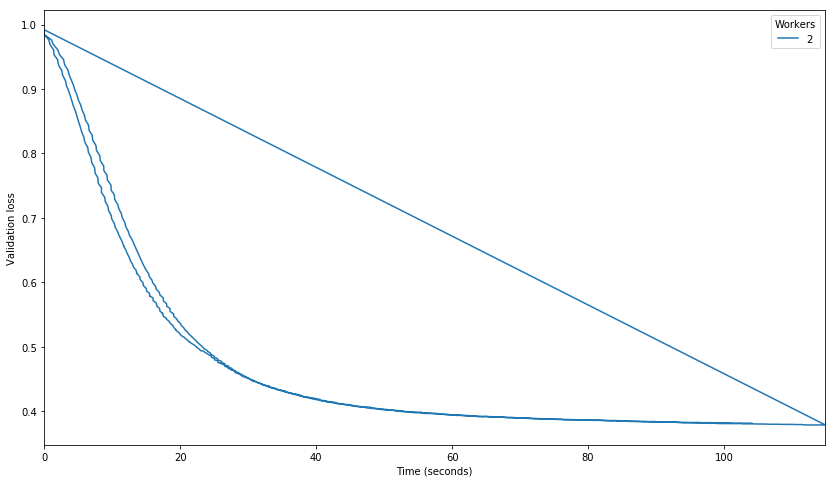

In [13]:
plot_all(batch_size=256)

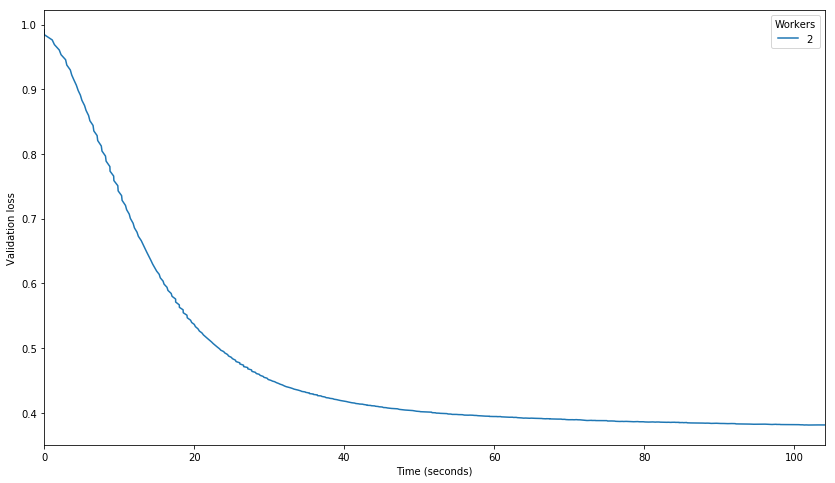

In [4]:
plot_all(batch_size=256)

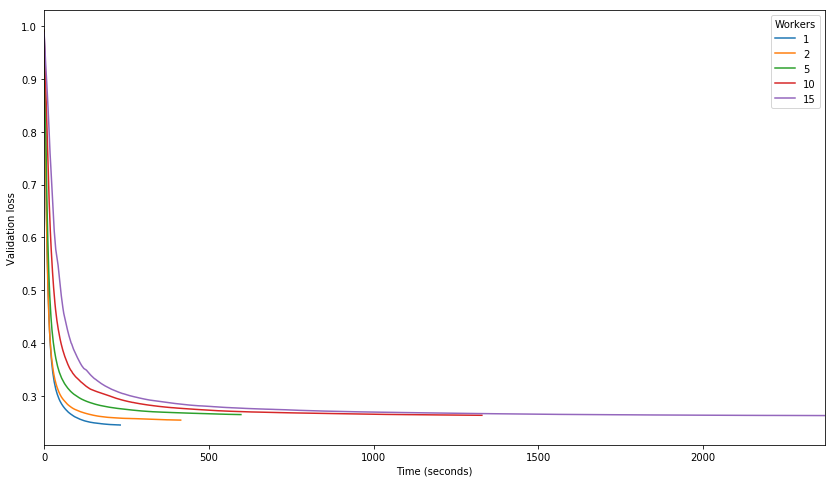

In [26]:
plot_all(batch_size=256)

In [24]:
data

end_time  \
WORKERS BATCH_SIZE EPOCHS LEARNING_RATE PATIENCE epoch                 
5       256        10000  0.03          50       0          0.000000   
                                                 1          0.497526   
                                                 2          1.056726   
                                                 3          1.553264   
                                                 4          2.063213   
                                                 5          2.669222   
                                                 6          3.277504   
                                                 7          3.830376   
                                                 8          4.341473   
                                                 9          4.785985   
                                                 10         5.345102   
                                                 11         5.796988   
                                                 12         6.326868   
                                                 13         6.853060   
                                                 14         7.345824   
                                                 15         7.862156   
                                                 16         8.386275   
                                                 17         8.969077   
                                                 18         9.474387   
                                                 19        10.027970   
                                                 20        10.541788   
                                                 21        11.058478   
                                                 22        11.626519   
                                                 23        12.261508   
                                                 24        12.784695   
                                                 25        13.455958   
                                                 26        14.045437   
                                                 27        14.583980   
                                                 28        15.151900   
                                                 29        15.678606   
...                                                              ...   
10      256        10000  0.03          50       9971   11731.202504   
                                                 9972   11732.783943   
                                                 9973   11733.996402   
                                                 9974   11735.177107   
                                                 9975   11736.174086   
                                                 9976   11737.186687   
                                                 9977   11738.201581   
                                                 9978   11739.304471   
                                                 9979   11740.276989   
                                                 9980   11741.396979   
                                                 9981   11742.386602   
                                                 9982   11743.594423   
                                                 9983   11744.690001   
                                                 9984   11745.705137   
                                                 9985   11746.798317   
                                                 9986   11747.996144   
                                                 9987   11749.101379   
                                                 9988   11750.387651   
                                                 9989   11751.580439   
                                                 9990   11752.898620   
                                                 9991   11753.994792   
                                                 9992   11755.179700   
                                                 9993   11756.294981   
                            

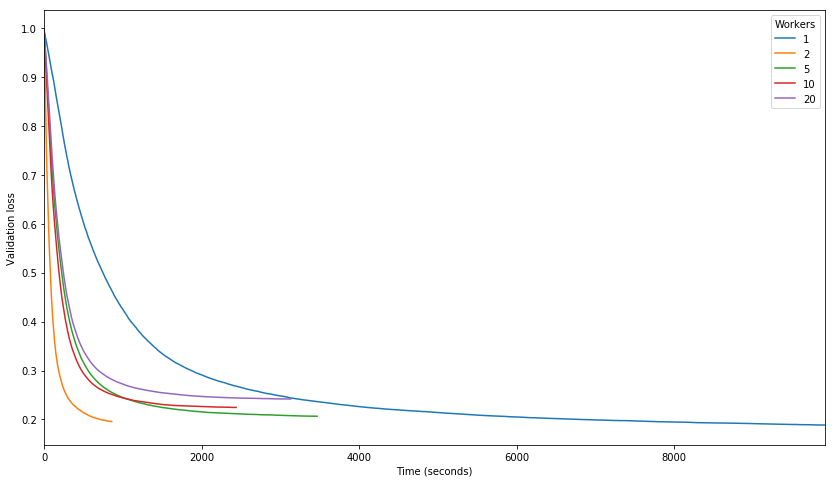

In [12]:
plot_all(batch_size=128)

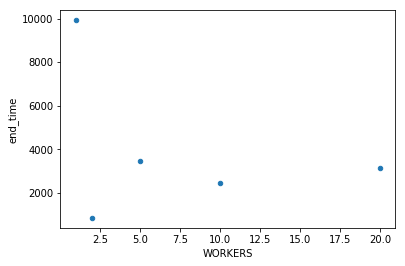

In [13]:
d = data.groupby(level=["WORKERS",  "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE"])["end_time"].max()
d = d[np.in1d(d.index.get_level_values(1), [128])].to_frame()
d.reset_index().plot(kind='scatter', x="WORKERS", y="end_time")

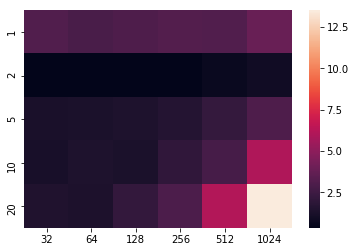

In [19]:
workers_value = sorted(map(int, data.index.levels[0].values))
batch_value = sorted(map(int, data.index.levels[1].values))
times = np.zeros((len(workers_value), len(batch_value)))
workers_idx = {w: i for i, w in enumerate(workers_value)}
batch_idx = {w: i for i, w in enumerate(batch_value)}
for idx, df in data.groupby(level=["WORKERS",  "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE"]):
    times[workers_idx[idx[0]], batch_idx[idx[1]]] = (df["end_time"] - df["end_time"].shift(1)).mean()
d = pd.DataFrame(times, columns=batch_idx.keys(), index=workers_idx.keys())
sns.heatmap(d);